In [1]:
%cd C:/Users/realc/OneDrive/Documents/GSOC

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.angle_encoding_script import angle_encoding
from utils.haar_noising_script import apply_haar_scrambling

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg

import pennylane as qml

c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\realc\OneDrive\Documents\GSOC


In [3]:
QG_channel = 1
filename = f"data/QG{QG_channel}_normalized_16x16_100k"
with h5py.File(filename, "r") as f:
    data_X = np.array(f['X'])
    labels_y = np.array(f['y']) 

data_X_quarks = data_X[labels_y == 0]  # quarks i think
data_X_gluons = data_X[labels_y == 1]  # gluons


num_samples = 100

data_X = data_X_gluons
encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = torch.tensor(np.array(encoded_data), dtype=torch.float32)
print(encoded_data.shape)

scrambled_states = apply_haar_scrambling(np.array(encoded_data), num_samples, seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
print(scrambled_states.shape)

torch.Size([100, 8, 8, 4])
torch.Size([100, 8, 8, 4])


C:\Users\realc\AppData\Local\Temp\ipykernel_2516\64002407.py:19: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:305.)
  scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)


Epoch [1/100], Loss: 1.0260, Val Loss: 0.7852, FID: 199.9212
Epoch [2/100], Loss: 0.7868, Val Loss: 0.5600, FID: 142.1813
Epoch [3/100], Loss: 0.5634, Val Loss: 0.3456, FID: 87.2139
Epoch [4/100], Loss: 0.3481, Val Loss: 0.1627, FID: 40.2879
Epoch [5/100], Loss: 0.1658, Val Loss: 0.0471, FID: 10.5744
Epoch [6/100], Loss: 0.0573, Val Loss: 0.0390, FID: 8.3811
Epoch [7/100], Loss: 0.0517, Val Loss: 0.1124, FID: 27.0233
Epoch [8/100], Loss: 0.1126, Val Loss: 0.1569, FID: 38.3275
Epoch [9/100], Loss: 0.1450, Val Loss: 0.1396, FID: 33.8898
Epoch [10/100], Loss: 0.1123, Val Loss: 0.0925, FID: 21.8374
Epoch [11/100], Loss: 0.0632, Val Loss: 0.0508, FID: 11.1900
Epoch [12/100], Loss: 0.0393, Val Loss: 0.0272, FID: 5.2051
Epoch [13/100], Loss: 0.0283, Val Loss: 0.0189, FID: 3.0909
Epoch [14/100], Loss: 0.0254, Val Loss: 0.0184, FID: 2.9726
Epoch [15/100], Loss: 0.0285, Val Loss: 0.0203, FID: 3.4818
Epoch [16/100], Loss: 0.0294, Val Loss: 0.0220, FID: 3.9294
Epoch [17/100], Loss: 0.0313, Val Los

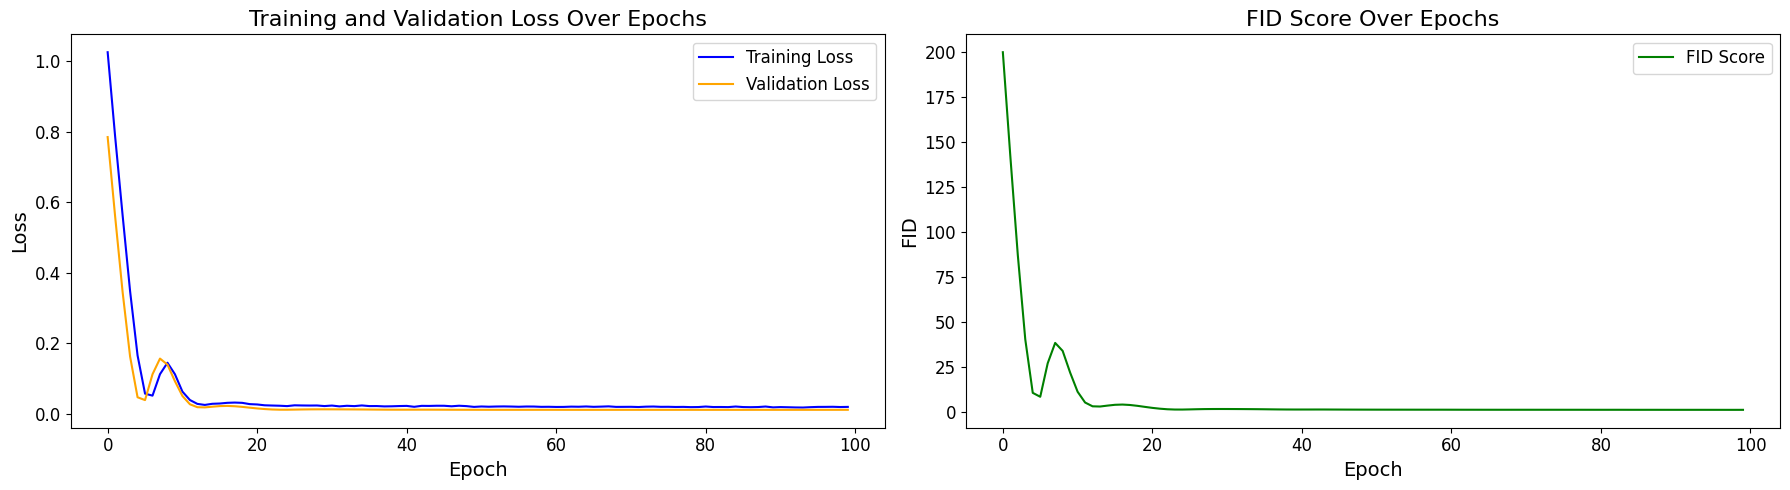

In [10]:
train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data[:num_samples], scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QuantumLayer, self).__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

class QuantumDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(QuantumDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, n_qubits)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers)
        self.fc2 = nn.Linear(n_qubits, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.quantum_layer(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

n_layers = 8
input_dim = 8 * 8 * 4 
hidden_dim = 128
output_dim = input_dim  

model = QuantumDiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
loss_values = []
val_loss_values = []
fid_scores = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), -1))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), -1))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

        mu1, sigma1 = calculate_statistics(data_X[:len(decoded_data)])
        mu2, sigma2 = calculate_statistics(decoded_data)
        fid = calculate_fid(mu1, sigma1, mu2, sigma2)
        fid_scores.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, FID: {fid:.4f}')

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(fid_scores, label='FID Score', color='green')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('FID', fontsize=14)
plt.title('FID Score Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

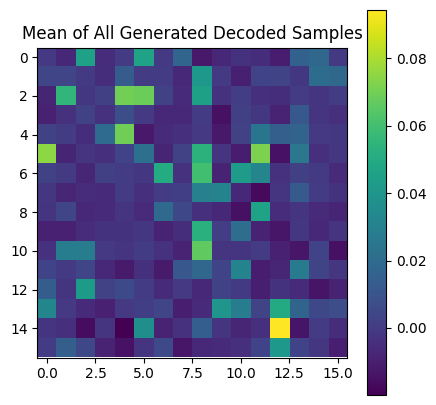

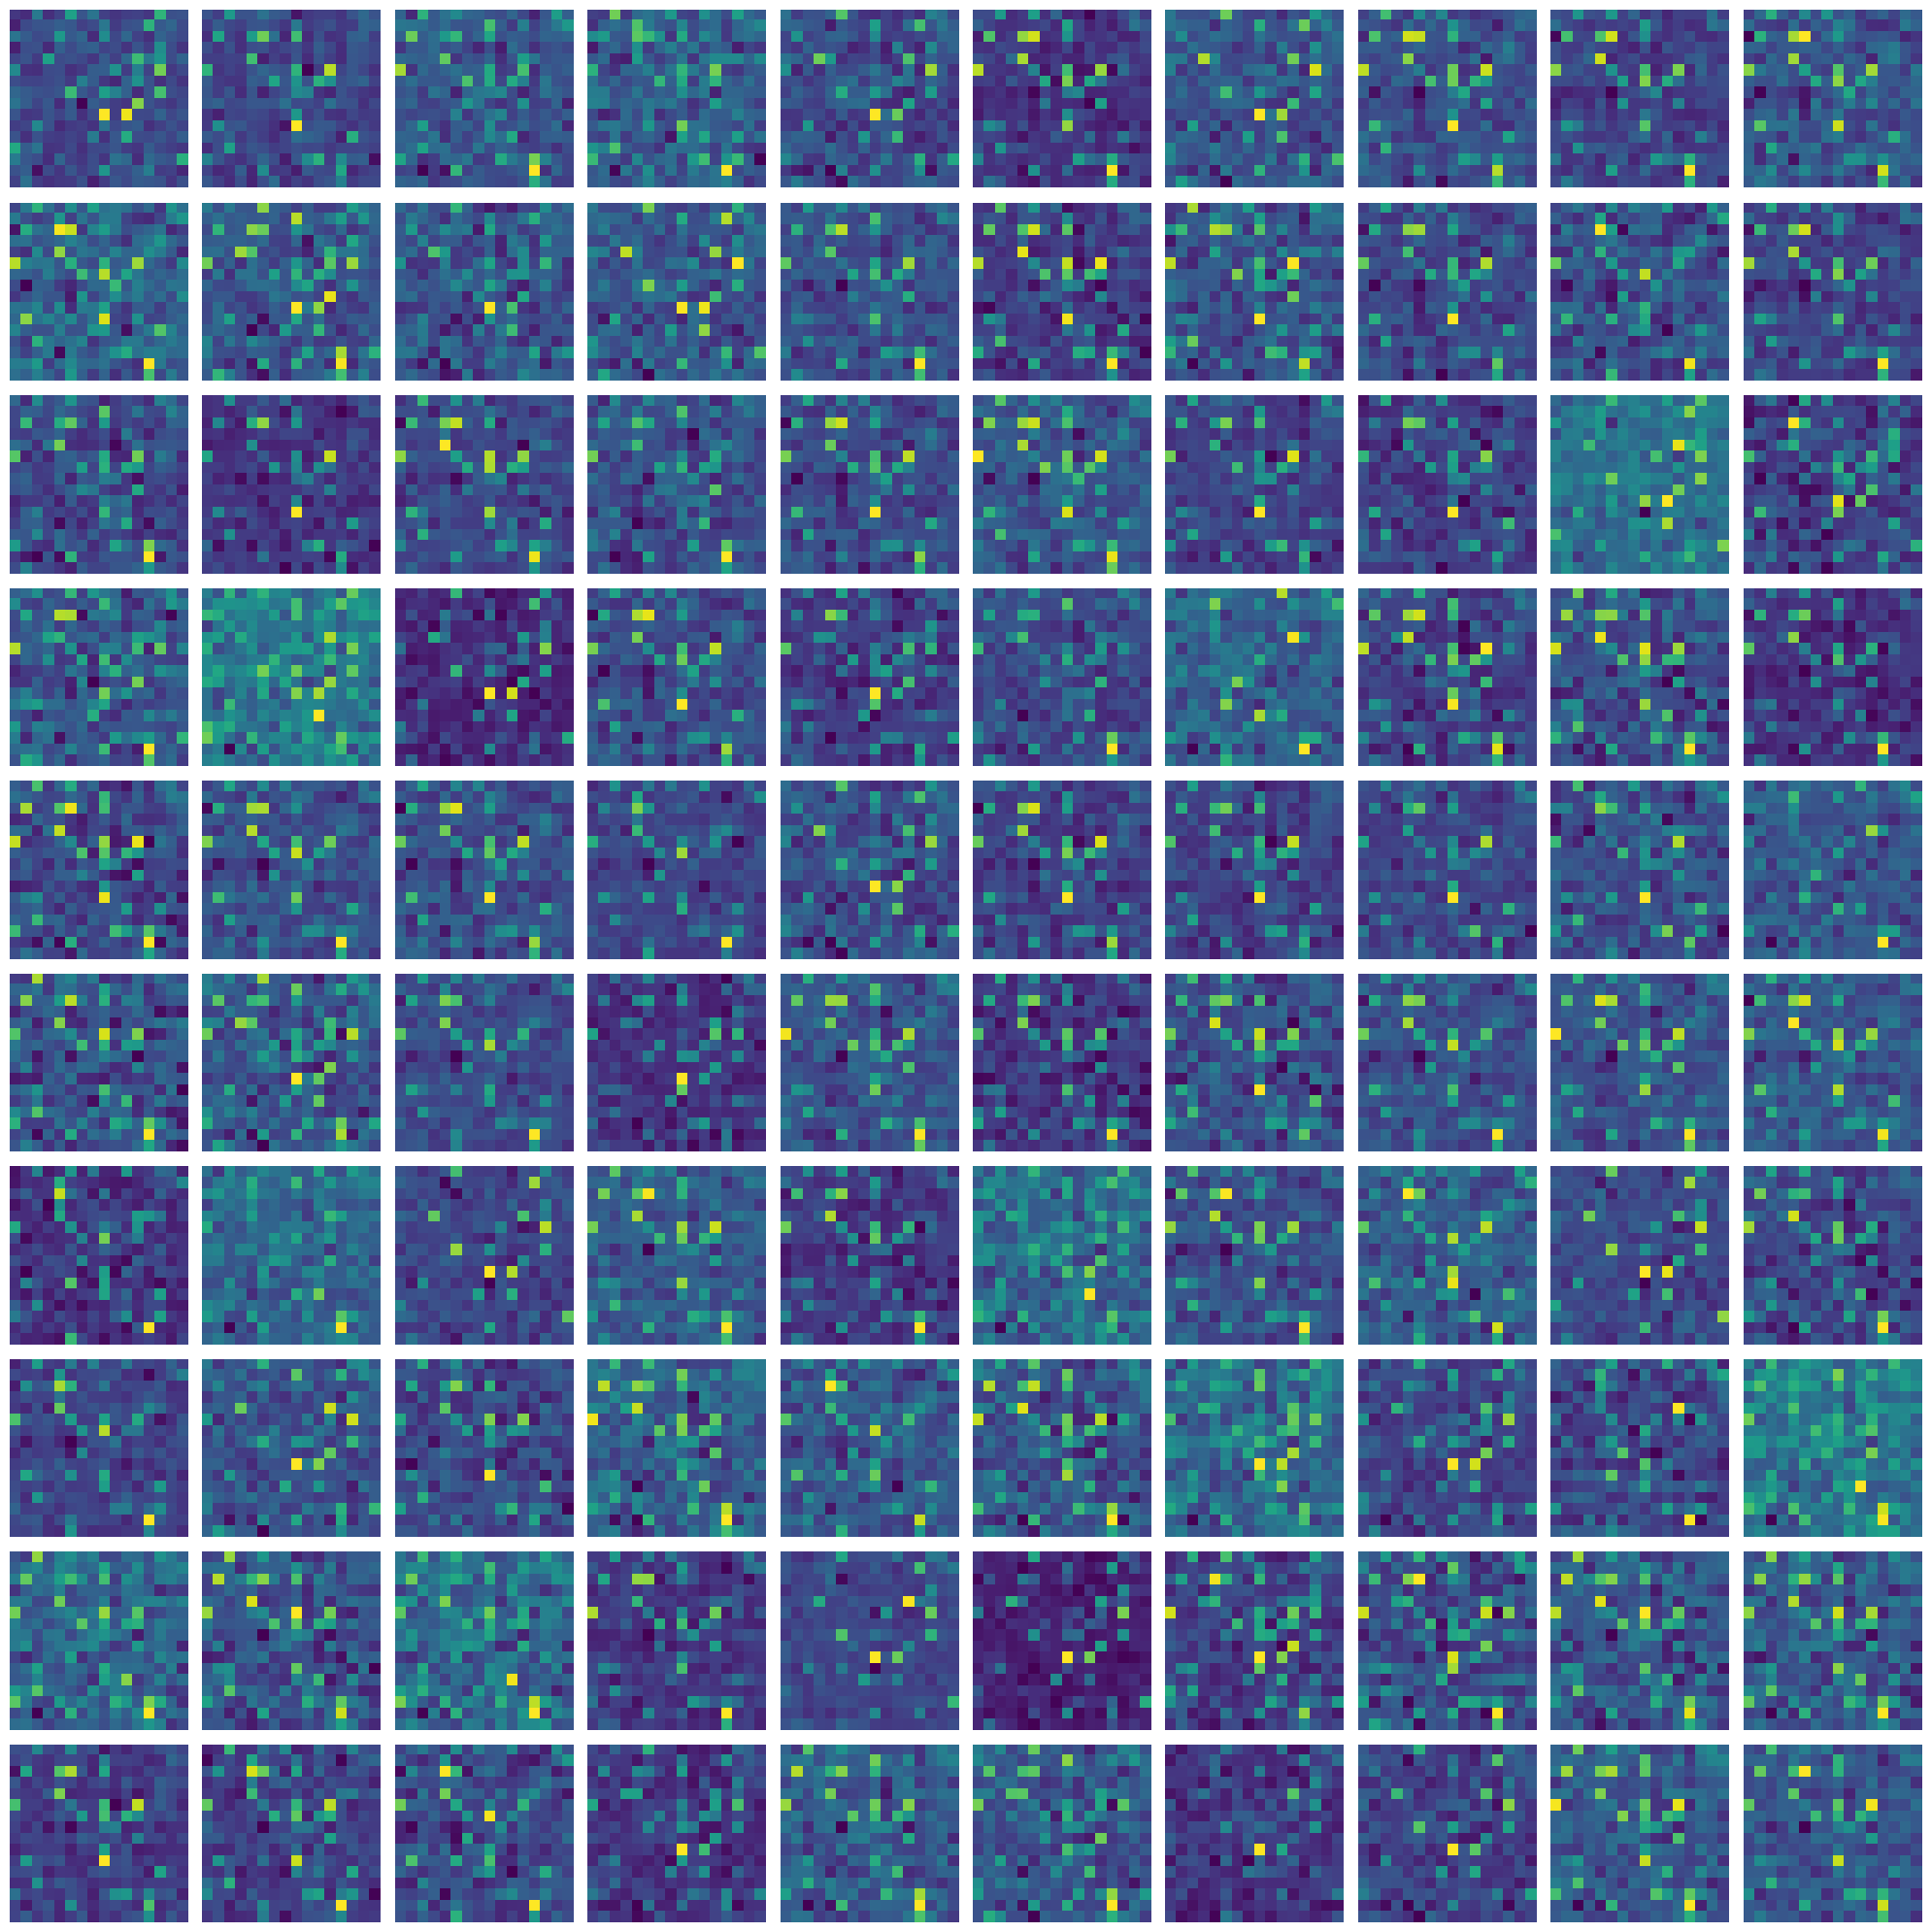

In [11]:
num_samples_to_generate = 100
new_images = generate_new_images(model, num_samples_to_generate)
plot_mean_decoded_images(new_images)
plot_all_decoded_images(new_images, grid_size=(10, 10))

In [13]:
generated_data = new_images

real_data = data_X[:len(generated_data)]

mu_real, sigma_real = calculate_statistics(real_data)
mu_gen, sigma_gen = calculate_statistics(generated_data)
fid = calculate_fid(mu_real, sigma_real, mu_gen, sigma_gen)
print("FID ", fid)

wasserstein_value = calculate_wasserstein(real_data, generated_data)
print("Wasserstein 1 ", wasserstein_value)

FID  0.9081277721502157
Wasserstein 1  0.022581645878963174


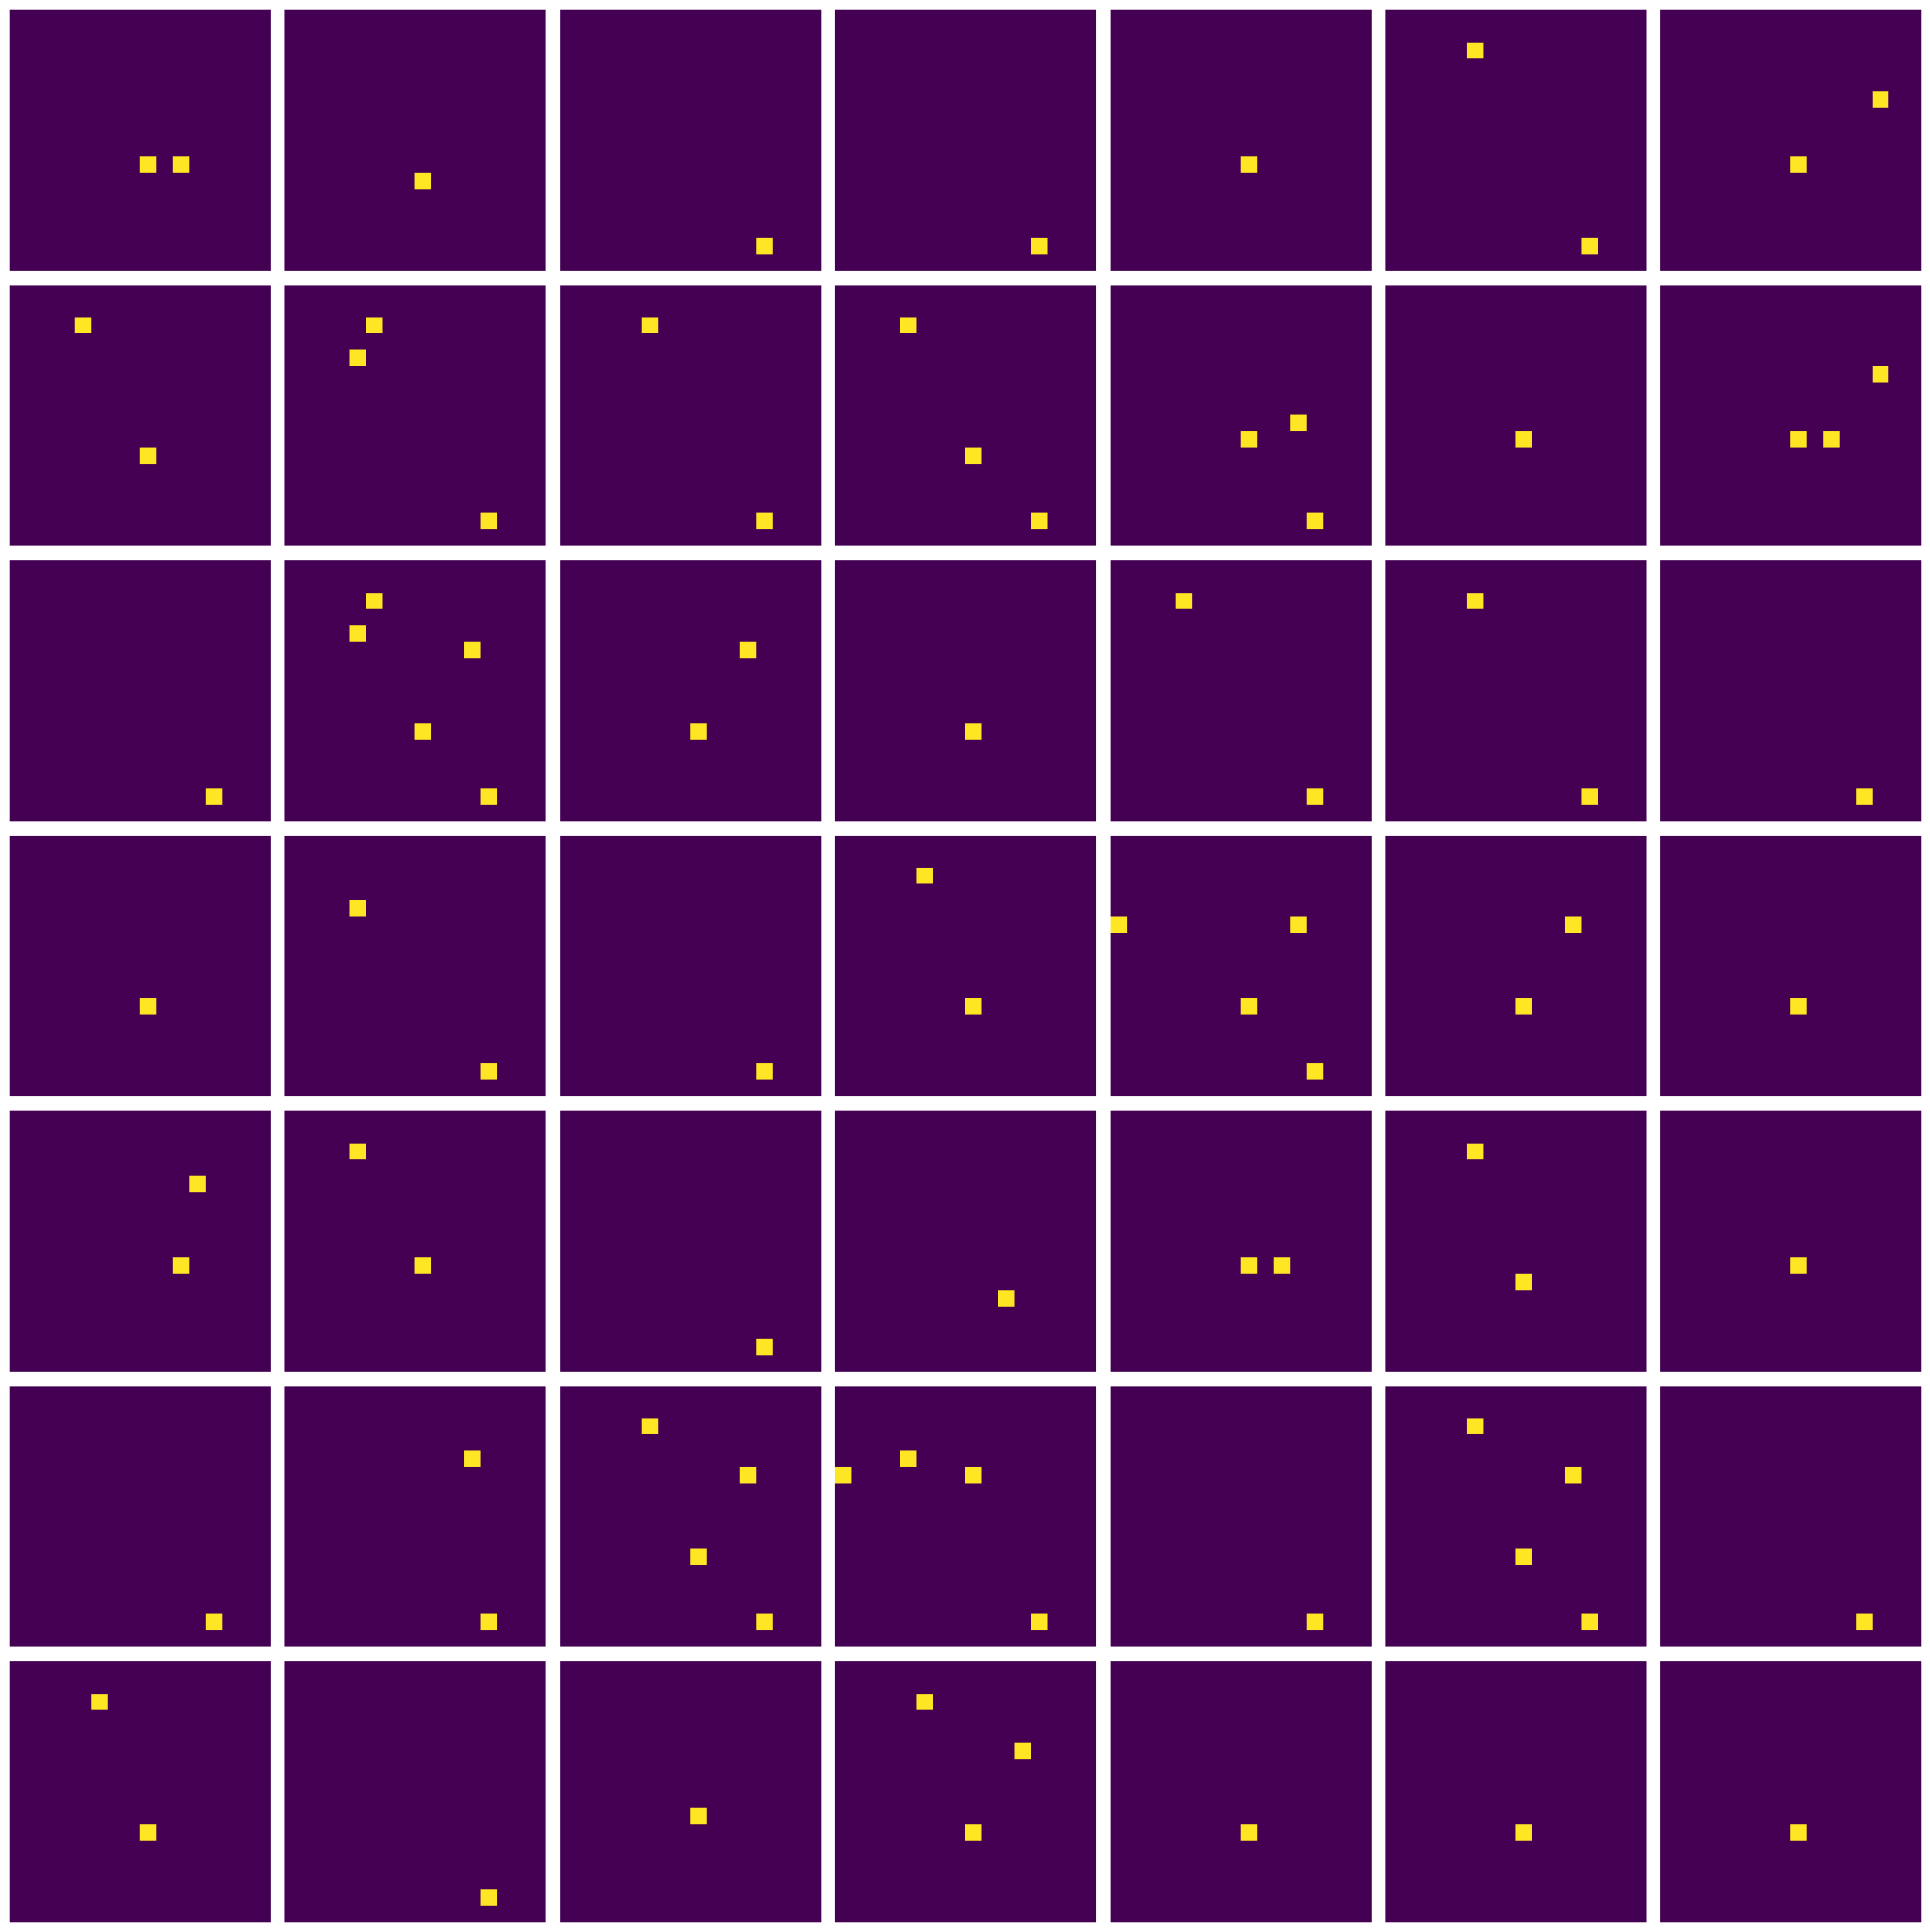

In [14]:
def plot_decoded_images_without_noise(decoded_images, grid_size=(4, 4)):
    num_images = decoded_images.shape[0]
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))

    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if (i * grid_size[1] + j) < num_images:
                image = decoded_images[i * grid_size[1] + j]

                median_val = np.median(image)
                max_val = np.max(image)

                image_without_noise = np.where(image > (max_val-median_val)*9/10 + median_val, 1.0, 0.0)

                axes[i, j].imshow(image_without_noise, cmap='viridis')
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

plot_decoded_images_without_noise(new_images, grid_size=(7, 7))